# Archivos de entrada para IPF-FDMC

El código de onda completa IPF-FDMC necesita de un mapa de contorno de la densidad electrónica y un mapa de contorno del campo magnético. A continuación se realizan todos los pasos necesarios para ello.

In [1]:
#Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #gráficos
from scipy import interpolate #interpolación 1
from scipy.interpolate import griddata #interpolación 2
import h5py #archivos en hdf5

In [2]:
#Datos de VMEC - coordenadas de superficies de flujo y campo magnético
def variables_vmec(ruta, file):
    #librerías
    from pathlib import Path, PurePath #manejo de rutas y archivos
    import netCDF4 as nc
    
    #archivo netcdf 
    #Manual https://towardsdatascience.com/read-netcdf-data-with-python-901f7ff61648 
    ruta_archivo = PurePath(Path(ruta), Path(file))
    datos_vmec = nc.Dataset(ruta_archivo)
    #Control archivo
    #print(datos_vmec)
    
    #Extracción de variables de VMEC
    #https://github.com/jonathanschilling/vmec-internals/blob/master/vmec_var_names.pdf
    #Radial nodes
    ns = datos_vmec['ns'][:]
    #Field periods
    nfp = datos_vmec['nfp'][:]
    
    #Coordenadas
    #Poloidal mode numbers
    xm = datos_vmec['xm'][:]
    xm = np.expand_dims(xm, axis=1) #matriz
    #Toroidal mode numbers
    xn = datos_vmec['xn'][:]
    xn = np.expand_dims(xn, axis=1) #matriz
    #Poloidal modes
    mpol = datos_vmec['mpol'][:]
    #cosmn component of cylindrical R
    rmnc = datos_vmec['rmnc'][:]
    #sinmn component of cylindrical Z
    zmns = datos_vmec['zmns'][:]
    
    #campo magnético
    bmnc = datos_vmec['bmnc'][:]
    xm_nyq = datos_vmec['xm_nyq'][:]
    xm_nyq = np.expand_dims(xm_nyq, axis=1) #matriz
    xn_nyq = datos_vmec['xn_nyq'][:]
    xn_nyq = np.expand_dims(xn_nyq, axis=1) #matriz

    
    #construcción de coordenadas, formato coordenada(superficie, datos, ángulo)
    #https://github.com/jonathanschilling/vmec-internals/blob/master/scalars.pdf
    
    nu = 40 #ntheta en input VMEC
    nv = 24 * nfp #nzeta = 48
    theta = np.ndarray((nu,1))
    zeta = np.ndarray((nv,1))
    for i in range(nu): 
        theta[i] = (2*np.pi*i)/(nu-1)
    for i in range(nv): 
        zeta[i] = (2*np.pi*i)/(nv-1)
    
    #coordenada R
    r_vmec=0
    (___,mn)=rmnc.shape
    lt = len(theta)
    lz = len(zeta)
    mt= xm.dot(theta.T)
    nz=np.matmul(xn,zeta.T)
    cosmt=np.cos(mt)
    sinmt=np.sin(mt)
    cosnz=np.cos(nz)
    sinnz=np.sin(nz)
    r_vmec = np.zeros((ns,lt,lz))
    rmn = np.ndarray((mn,lt))
    for k_r in range(ns):
        rmn = np.broadcast_to(rmnc[k_r,:],(lt,mn)).T
        rmncosmt=(rmn*cosmt).T
        rmnsinmt=(rmn*sinmt).T
        #f[k,:,:]=np.matmul(fmncosmt, cosnz)-np.matmul(fmnsinmt, sinnz) #no funciona matmul
        r_vmec[k_r,:,:]= rmncosmt.dot(cosnz)- rmnsinmt.dot(sinnz)
    
    #coordenada Z
    z_vmec=0
    z_vmec = np.zeros((ns,lt,lz))
    zmn = np.ndarray((mn,lt))
    for k_z in range(ns):
        zmn = np.broadcast_to(zmns[k_z,:],(lt,mn)).T
        z_vmec[k_z,:,:]=(zmn*sinmt).T.dot(cosnz) + (zmn*cosmt).T.dot(sinnz)
        
    #campo magnético
    b_vmec = 0
    (___,mnb)=bmnc.shape
    mt_nyq= xm_nyq.dot(theta.T)
    nz_nyq=np.matmul(xn_nyq,zeta.T)
    cosmt_nyq=np.cos(mt_nyq)
    sinmt_nyq=np.sin(mt_nyq)
    cosnz_nyq=np.cos(nz_nyq)
    sinnz_nyq=np.sin(nz_nyq)
    b_vmec = np.zeros((ns,lt,lz))
    bmn = np.ndarray((mnb,lt))
    for k_b in range(ns):
        bmn = np.broadcast_to(bmnc[k_r,:],(lt,mnb)).T
        bmncosmt=(bmn*cosmt_nyq).T
        bmnsinmt=(bmn*sinmt_nyq).T
        b_vmec[k_b,:,:]= bmncosmt.dot(cosnz_nyq)- bmnsinmt.dot(sinnz_nyq)
    #Plot superficies
    #rango = range(0,38,4)
    #plt.plot(r_vmec[rango,:,47].T, z_vmec[rango,:,47].T)
    #plt.plot(r_vmec[:,:,0].T,b_vmec[:,:,0].T)
    #print(np.average(b_vmec[:,:,0].T))
    return r_vmec, z_vmec   

In [3]:
r_vmec, z_vmec = variables_vmec('input_VMEC', 'wout_scr_free.nc')

In [4]:
#Ajustar uno o varios perfiles de densidad electrónica
#Exportar las matrices r,z,n_e
n_e = np.loadtxt("./ne_Te_r_z_B/densidad.txt")
T_e = np.loadtxt('./ne_Te_r_z_B/temperatura.txt')
r_BS, z_BS, B_x,B_y,B_z = np.loadtxt('./ne_Te_r_z_B/r+z+B_mag_componentes.txt', 
                            usecols=(0, 1, 2, 3, 4), unpack=True)

def eliminar_eje_magnetico(r_1, z_1):
    #Se elimina el eje magnético
    indice_eje_magnetico = 0
    r = np.delete(r_1, indice_eje_magnetico, axis=0)
    z = np.delete(z_1,indice_eje_magnetico, axis=0)
    #control
    #print(r.shape)
    return r,z
 
#Sacar el campo del archivo de BS-Solctra - componente x,y,z
def campo_magnetico_mapa(r,z):
    nr = r.shape[0]   #cantidad de datos en r
    nz = z.shape[0]
    sup = []
    sup1 = []
    for i in range(nr):
        sup1 = np.array([r[i], z[i]]).tolist() 
        sup.append(sup1[:])
        #Bx.append(B_x[i])

    superficie = np.asarray([np.asarray(xi) for xi in sup])
    return superficie



def densidad_electronica_mapa(r,z,n_e, T_e) : #correcta - 
    #matriz de almacenamiento
    sup2 = []
    ne = []
    Te = []
    #forma
    nFilas, ncolumnas, nangulos = r.shape
    #identificar cada superficie magnética
    k=0
    for i in range(nFilas):
        sup = []
        sup1 = []
        for j in range(ncolumnas):
            sup1 = np.array([r[i,j,0], z[i,j,0]]).tolist() #contador k para la densidad
            ne.append(n_e[i])
            Te.append(T_e[i])
            sup.append(sup1[:])
        sup2.append(sup[:])
        k += 1
    
    superficie = np.asarray([np.asarray(xi) for xi in sup2])
    nelect = np.asarray(ne, dtype=float)
    Telect = np.asarray(Te, dtype=float)
    superficie_2D = np.reshape(superficie, (nFilas*ncolumnas,2)) #pares en el orden para interpolación
    #Control
    print(superficie.shape)
    print(superficie_2D.shape)
    print(nelect.shape)
    #plt.plot(superficie[0,:,0], superficie[0,:,1])
    #plt.show()
    
    return superficie_2D, nelect, Telect


#Cada superficie de flujo presenta la misma densidad
def densidad_electronica_mapa_1(r,z,n_e) :

    #eje magnético
    eje_mag = np.array([0.2477, 0])

    #matriz de almacenamiento
    sup2 = []
    r_mayor = []
    ne = []


    #identificar cada superficie magnética
    nFilas = len(z.T) #largo

    k=0


    for i in range(nFilas):
        sup = []
        sup1 = []
        if z[i] == 0 and k != 98:
            r_mayor.append(r[i].tolist())#se obtienen los radios mayores
            for j in range(101):
                sup1 = np.array([r[i+j],z[i+j]]).tolist() #contador k para la densidad
                ne.append(n_e[k])
                sup.append(sup1[:])
            sup2.append(sup[:])
            k += 1

    superficie = np.asarray([np.asarray(xi) for xi in sup2])
    Rmayor = np.array([np.array(yi) for yi in r_mayor], dtype=float)
    nelect = np.array(ne, dtype=float)
    superficie_2D = np.reshape(superficie, (9898,2)) #pares en el orden para interpolación
    
    #control
    #plt.plot(superficie[2][:,0], superficie[2][:,1])
    #plt.plot(superficie[97][:,0], superficie[90][:,1])
    #plt.plot(superficie[80][:,0], superficie[80][:,1])
    #plt.show()
    
    return superficie_2D, nelect

#superficie_2D, ne1 = densidad_electronica_mapa(r,z,n_e)

#print(ne1.shape)
#print(superficie_2D.shape)
#print(Rmayor.shape)
#print(np.min(Rmayor))
#print(np.max(Rmayor))
#return superficie, nelect

In [5]:
r,z = eliminar_eje_magnetico(r_vmec, z_vmec)
s2DB = campo_magnetico_mapa(r_BS, z_BS)
superficie_2D, ne1, Te1 = densidad_electronica_mapa(r,z,n_e, T_e)

(98, 40, 2)
(3920, 2)
(3920,)


In [6]:
#Gráficos de densidad y campo magnético

#Revisar este grid para los inputs
#grid_r, grid_z = np.mgrid[-0.29086592:0.79359292:4534j, -0.51869842:0.51869782:4338j] #create a mesh grid for the full wave code (512 grid points/wavelength) 4 wavelengths
#grid_r, grid_z = np.mgrid[0.198930:0.303797:219j, -0.0289025:0.0289019:121j] #cero grados  
    #grid_r, grid_z = np.mgrid[-0.29086592:0.79359292:4534j, -0.51869842:0.51869782:4338j] #create a mesh grid for the full wave code (512 grid points/wavelength) 4 wavelengths - correcto
    #grid_r, grid_z = np.mgrid[-0.4133149:0.9160419:5558j, -0.6411474:0.64123509:5362j] #create a mesh grid for the full wave code (512 grid points/wavelength) 5 wavelengths
    

def input_campo(superficie_2D, Bx,By,Bz):
    
    #Graficación
    #cero grados - BSSolctra
    #grid_r, grid_z = np.mgrid[0.1957178997475323:0.3060799:219j, -0.03031574:0.03031574:121j]
    #grid_r, grid_z = np.mgrid[0.1957178997475323:0.3060799:297j, -0.03031574:0.03031574:165j] #para output 
    
    #Final para inputs
    #create a mesh grid for the full wave code (512 grid points/wavelength) 5 wavelengths-correcto- BS-Solctra
    grid_r, grid_z = np.mgrid[-0.4161034431:0.9179012429:5558j, -0.6421370829:0.6421370829:5362j] 
    
    #Interpolación 1:griddata
    grid_Bx = griddata(superficie_2D, np.abs(Bx), (grid_r, grid_z), method='linear', fill_value = 0)
    grid_By = griddata(superficie_2D, np.abs(By), (grid_r, grid_z), method='linear', fill_value = 0)
    grid_Bz = griddata(superficie_2D, np.abs(Bz), (grid_r, grid_z), method='linear', fill_value = 0)
    
    #Control gráfico
    cmap= "cividis" # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    #contorno_B = plt.imshow(grid_By.T, interpolation ='kaiser', 
                            #extent=(0.198930, 0.303797, -0.0289025, 0.0289019), cmap=cmap)
    contorno_B = plt.imshow(grid_By.T, interpolation ='kaiser', 
                            extent=(0.1957178997475323, 0.3060799, -0.03031574, 0.03031574), cmap=cmap)

    ac = plt.colorbar(contorno_B, orientation='vertical', shrink=0.8)
    #plt.plot(r, z, 'o')
    
    plt.show()
    return grid_Bx, grid_By, grid_Bz

def input_densidad(superficie_2D, ne1):
    #Se crea una malla
    
    #Graficación
    #cero grados - BSSolctra
    #grid_r, grid_z = np.mgrid[0.1957178997475323:0.3060799:219j, -0.03031574:0.03031574:121j] 
    #grid_r, grid_z = np.mgrid[0.1957178997475323:0.3060799:297j, -0.03031574:0.03031574:165j] #para output de IPFFDMC
    
    #Final para inputs
    #create a mesh grid for the full wave code (512 grid points/wavelength) 5 wavelengths-correcto- BS-Solctra
    grid_r, grid_z = np.mgrid[-0.4161034431:0.9179012429:5558j, -0.6421370829:0.6421370829:5362j] 
    
    #Interpolación 1:griddata
    grid_ne = griddata(superficie_2D, ne1, (grid_r, grid_z), method='linear', fill_value = 0)
    
    #Control gráfico
    cmap= "cividis" # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    contorno_densidad = plt.imshow(grid_ne.T, extent=(0.198930, 0.303797, -0.0289025, 0.0289019), cmap=cmap)
    ac = plt.colorbar(contorno_densidad, orientation='vertical', shrink=0.8)
    plt.show()
    
    return grid_ne

def input_temperatura(superficie_2D, Te1):
    #Se crea una malla
    grid_r, grid_z = np.mgrid[0.198930:0.303797:219j, -0.0289025:0.0289019:121j] #cero grados - vmec

    #Interpolación 1:griddata
    grid_Te = griddata(superficie_2D, Te1.T, (grid_r, grid_z), method='cubic', fill_value = 0)
    
    #Control gráfico
    cmap= "cividis" # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    contorno_densidad = plt.imshow(grid_Te.T, extent=(0.198930, 0.303797, -0.0289025, 0.0289019), cmap=cmap)
    ac = plt.colorbar(contorno_densidad, orientation='vertical', shrink=0.8)
    plt.show()
    
    return grid_Te

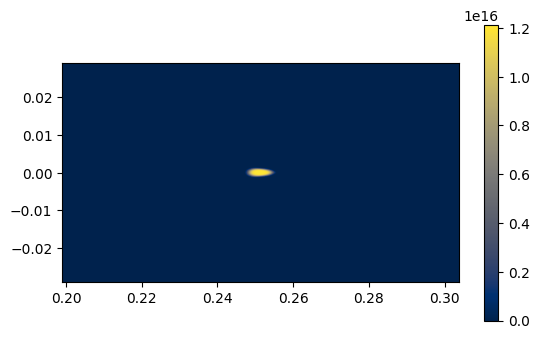

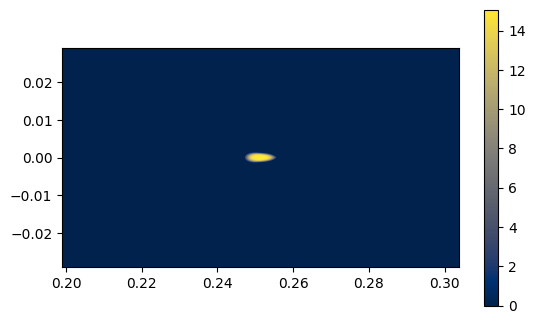

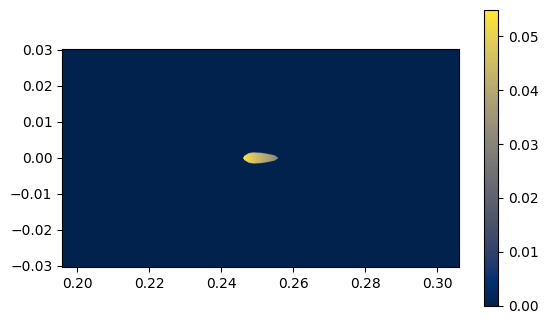

In [7]:
ne_interpol = input_densidad(superficie_2D, ne1)
Te_interpol = input_densidad(superficie_2D, Te1)
B_xint, B_yint, B_zint = input_campo(s2DB, B_x, B_y, B_z)

# Escenario

Escenario 3 : Similar al escenario 1 en densidad y campo magnético pero considera las reflexiones de la cámara.

El factor de ajuste de la densidad se corrigió de acuerdo con el resultado del balance de energía.

## Exportar archivos a hdf5

In [8]:
factor_B = 1.000

#hdf5 campo magnético
with h5py.File('magneticfield.h5', 'w' ) as h5file:
    h5file['X magnetic field'] = np.abs(factor_B*B_yint/ 43.8e-3)
    h5file['Y magnetic field'] = np.abs(factor_B*B_xint/ 43.8e-3)
    h5file['Z magnetic field'] = np.abs(factor_B*B_zint/ 43.8e-3)

In [9]:
#https://stackoverflow.com/questions/22922584/how-to-overwrite-array-inside-h5-file-using-h5py
def input_densidad_camara(file, factor_densidad):
    from pathlib import Path, PurePath #manejo de rutas y archivos
    ruta_archivo = PurePath(Path(file)) #archivo Alf
    with h5py.File(ruta_archivo,'r+') as ne:
        densidad_ref = ne['Density_ref'][...][...]
        densidad = ne['Density'][...][...]
        #indices_camara = np.where(ne['Density'][...][...] == 256.0)
        #print(indices_camara[0])
    with h5py.File('Density_nuevo.h5', 'w') as h5file:
        y_cont, x_cont = densidad.shape
        #Al ser la matrices del mismo tamaño, se recorre para la asignación
        nueva_n = np.ndarray((y_cont,x_cont), dtype=np.float64)
        for cont_1 in range(y_cont) :
            for cont_2 in range(x_cont) :
                if densidad[cont_1][cont_2] == 256.0 :
                    nueva_n[cont_1][cont_2] = densidad[cont_1][cont_2]
                else:
                    nueva_n[cont_1][cont_2] = factor_densidad*ne_interpol[cont_1][cont_2]/7.45e16
        print(nueva_n.shape)
        h5file['Density'] = nueva_n
        h5file['Density_ref'] = densidad_ref
        
#input_densidad_camara('Density_vessel.h5', 6.1405*1.48)
#input_densidad_camara('Density_vessel.h5', 6.1405*1.85)
input_densidad_camara('Density_vessel.h5', 6.1405*2.14)


(5558, 5362)


In [10]:
# Visualización del hdf5
from jupyterlab_h5web import H5Web #librería
#H5Web('magneticfield.h5')
#H5Web('Density_vessel.h5')
H5Web('Density_vc.h5')

<jupyterlab_h5web.widget.H5Web object>